In [1]:
from PIL import Image
from model import AggMInterface
from data import DInterface
import yaml
import warnings
warnings.filterwarnings("ignore")

# 指定模型的超参数配置文件路径和checkpoint文件路径
config_path = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_14/hparams.yaml"
checkpoint_path = "logs/dinov2_backbone_dinov2_large/lightning_logs/version_14/checkpoints/dinov2_backbone_epoch(39)_step(39080)_R1[0.9135]_R5[0.9595]_R10[0.9649].ckpt"

# 加载yaml文件，获取模型超参数配置
with open(config_path) as f:
    config = yaml.safe_load(f)

# 根据配置初始化数据模块
data_module = DInterface(**config)  # 数据模块初始化，传入配置参数
transform = data_module.valid_transform  # 获取验证集的数据变换方法

# 根据checkpoint文件路径加载模型，并设置为评估模式
model = AggMInterface.load_from_checkpoint(checkpoint_path)
model.eval()
model = model.model.model
model.requires_grad_(False)

/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/utils/hook_func.py:21: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [2]:
from torch.hub import load
import torch

model2 = load(
            # repo_or_dir="facebookresearch/dinov2",
            repo_or_dir='/home/cartolab3/.cache/torch/hub/facebookresearch_dinov2_main',
            model='dinov2_vitl14',
            trust_repo=True,
            source='local',
        )
model2.cuda()
model2.eval()
model2.requires_grad_(False)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


显著性图中值为True的像素数量: 669, 582
40 40
互为最佳匹配的点对数量: 585
基于显著性掩码过滤后的点对数量: 243


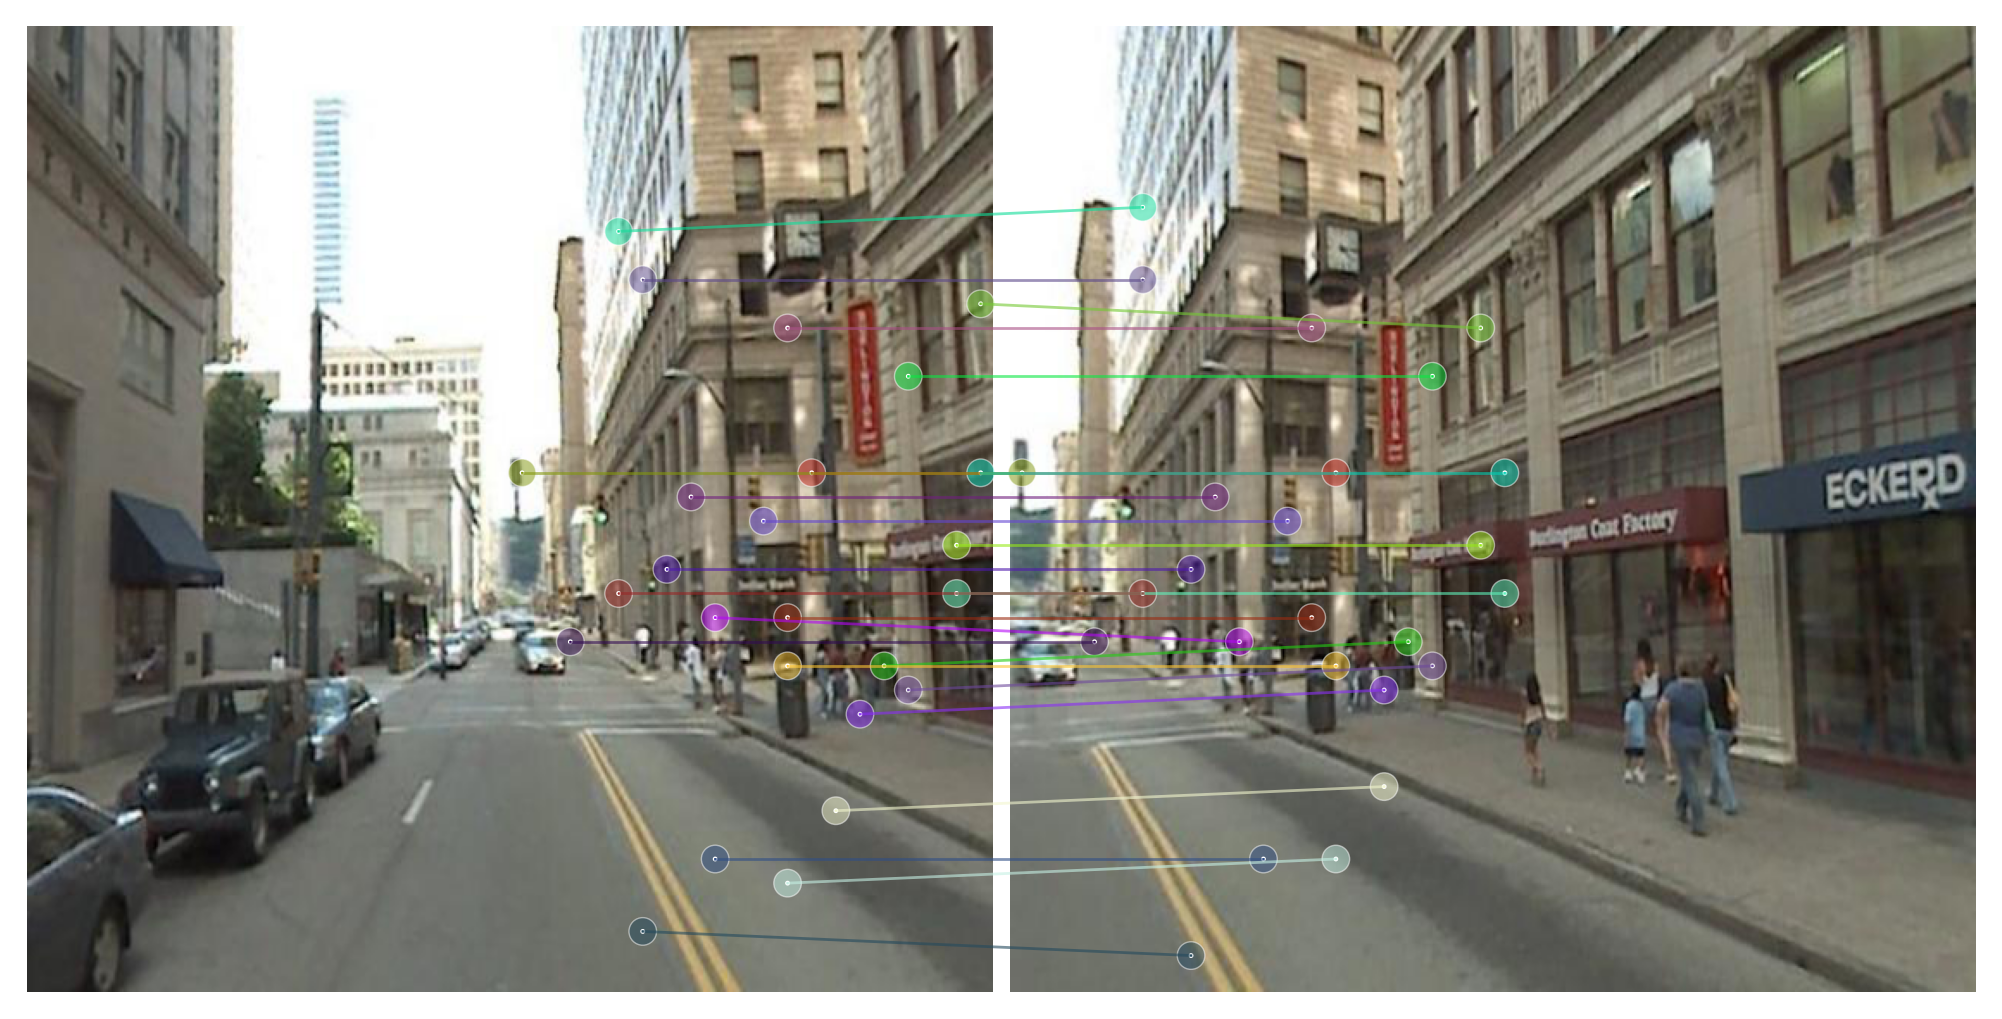

In [38]:
from utils.hook_func import find_correspondences, draw_correspondences, draw_correspondences_with_lines
from utils.hook_func import extract_saliency_maps
from visualization import visualize_saliency_maps
import os
import matplotlib.pyplot as plt
import glob


# 指定特征层和显著性图层
input_model = model
facet_layer_and_facet = {22: 'value'}
saliency_map_layer_and_facet = {23: 'attn'}
saliency_thresh = 0.5
best_buddies_thresh = 0.65
num_pairs = 25
bin = True
hierarchy = 4

image_path1 ='tmp_imgs/001185_pitch1_yaw7.jpg'
image_path2 ='tmp_imgs/001185_pitch1_yaw8.jpg'

output_folder = 'some_result_images/point_correspond/01'

image1_name=os.path.basename(image_path1)
image2_name=os.path.basename(image_path2)

# 可视化显著性图
image1 = Image.open(image_path1).convert("RGB")
image2 = Image.open(image_path2).convert("RGB")

# 应用数据变换并将图像转移到GPU
image1 = transform(image1).unsqueeze(0).cuda()
image2 = transform(image2).unsqueeze(0).cuda()

# 可视化显著性图
# saliency_map1 = extract_saliency_maps(input_model, saliency_map_layer_and_facet, image1)[0].cuda()  
# saliency_map2 = extract_saliency_maps(input_model, saliency_map_layer_and_facet, image2)[0].cuda()
# visualize_saliency_maps(image1, saliency_map1, alpha=0.6, cmap='jet', save_path=None, figsize=(4,4), sigma=1.0)
# visualize_saliency_maps(image2, saliency_map2, alpha=0.6, cmap='jet', save_path=None, figsize=(4,4), sigma=1.0)

# 计算对应点    
points1, points2, image1, image2 = find_correspondences(
    input_model,
    transform,  
    image_path1,
    image_path2,
    facet_layer_and_facet=facet_layer_and_facet,
    saliency_map_layer_and_facet=saliency_map_layer_and_facet,
    bin=bin,
    include_cls=False,
    saliency_thresh=saliency_thresh,
    num_pairs=num_pairs,
    hierarchy=hierarchy,
    best_buddies_thresh=best_buddies_thresh,
)

# 可视化对应点
fig = draw_correspondences_with_lines(points1, points2, image1, image2)
fig.show()
file_name = os.path.basename(image_path1).split(".")[0] + "_" + os.path.basename(image_path2).split(".")[0]
output_path = os.path.join(output_folder,file_name + ".png")

# 添加以下代码以移除空白边距
plt.tight_layout(pad=0)  # 设置padding为0
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # 调整子图位置以填充整个图像区域
fig.savefig(output_path, bbox_inches='tight', pad_inches=0)  # 保存时移除所有边距
# print(f"Correspondences saved to {output_path}")

In [3]:


input_folder = 'sample_imgs/msls'
output_folder = f'some_result_images/point_corrspond_and_saliency/{input_folder.split("/")[-1]}'

instances= os.listdir(input_folder)
for instance in instances:

    if not os.path.exists(os.path.join(output_folder,instance)):
        os.makedirs(os.path.join(output_folder,instance))

    query_imgs=glob.glob(os.path.join(input_folder,instance,'query','*.jpg'))+glob.glob(os.path.join(input_folder,instance,'query','*.png'))
    ref_imgs=glob.glob(os.path.join(input_folder,instance,'ref','*.jpg'))+glob.glob(os.path.join(input_folder,instance,'ref','*.png'))

    for query_img in query_imgs:
        for ref_img in ref_imgs:

            image_path1 = query_img
            image_path2 = ref_img

            image1_name=os.path.basename(image_path1)
            image2_name=os.path.basename(image_path2)

            # 可视化显著性图
            image1 = Image.open(image_path1).convert("RGB")
            image2 = Image.open(image_path2).convert("RGB")

            # 应用数据变换并将图像转移到GPU
            image1 = transform(image1).unsqueeze(0).cuda()
            image2 = transform(image2).unsqueeze(0).cuda()

            # 可视化显著性图
            saliency_map1 = extract_saliency_maps(input_model, saliency_map_layer_and_facet, image1)[0].cuda()  
            saliency_map2 = extract_saliency_maps(input_model, saliency_map_layer_and_facet, image2)[0].cuda()
            visualize_saliency_maps(image1, saliency_map1, alpha=0.6, cmap='jet', save_path=os.path.join(output_folder,instance,image1_name), figsize=(4,4), sigma=1.0)
            visualize_saliency_maps(image2, saliency_map2, alpha=0.6, cmap='jet', save_path=os.path.join(output_folder,instance,image2_name), figsize=(4,4), sigma=1.0)

            # 计算对应点    
            points1, points2, image1, image2 = find_correspondences(
                input_model,
                transform,  
                image_path1,
                image_path2,
                facet_layer_and_facet=facet_layer_and_facet,
                saliency_map_layer_and_facet=saliency_map_layer_and_facet,
                bin=bin,
                include_cls=False,
                saliency_thresh=saliency_thresh,
                num_pairs=num_pairs,
                hierarchy=hierarchy,
                best_buddies_thresh=best_buddies_thresh,
            )

            # 可视化对应点
            fig = draw_correspondences_with_lines(points1, points2, image1, image2)
            fig.show()
            file_name = os.path.basename(image_path1).split(".")[0] + "_" + os.path.basename(image_path2).split(".")[0]
            output_path = os.path.join(output_folder,instance,file_name + ".png")

            # 添加以下代码以移除空白边距
            plt.tight_layout(pad=0)  # 设置padding为0
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # 调整子图位置以填充整个图像区域
            fig.savefig(output_path, bbox_inches='tight', pad_inches=0)  # 保存时移除所有边距
            print(f"Correspondences saved to {output_path}")


显著性图中值为True的像素数量: 1563, 1569
40 40
互为最佳匹配的点对数量: 235
基于显著性掩码过滤后的点对数量: 230
Correspondences saved to some_result_images/point_corrspond_and_saliency/msls/67/dQ0Cjjk2DmZ-Pt30pK9fsg_Q6BAIxJpYEmXXd85OkcYB-.tif
显著性图中值为True的像素数量: 1563, 1512
40 40
互为最佳匹配的点对数量: 176
基于显著性掩码过滤后的点对数量: 170
Correspondences saved to some_result_images/point_corrspond_and_saliency/msls/67/dQ0Cjjk2DmZ-Pt30pK9fsg_KthIXosyLdgiyLr_u1oHDm.tif
显著性图中值为True的像素数量: 1563, 1502
40 40
互为最佳匹配的点对数量: 163
基于显著性掩码过滤后的点对数量: 155
Correspondences saved to some_result_images/point_corrspond_and_saliency/msls/67/dQ0Cjjk2DmZ-Pt30pK9fsg_c_FJF8oeEBTAkb-nsgP8Fb.tif
显著性图中值为True的像素数量: 1563, 1527
40 40
互为最佳匹配的点对数量: 215
基于显著性掩码过滤后的点对数量: 207
Correspondences saved to some_result_images/point_corrspond_and_saliency/msls/67/dQ0Cjjk2DmZ-Pt30pK9fsg_jLCNYXsCpZk8JBKboFUkZK.tif
显著性图中值为True的像素数量: 1563, 1511
40 40
互为最佳匹配的点对数量: 180
基于显著性掩码过滤后的点对数量: 169
Correspondences saved to some_result_images/point_corrspond_and_saliency/msls/67/dQ0Cjjk2DmZ-Pt30pK9fsg_uI1OGao

KeyboardInterrupt: 